# Model training

For this demo we'll use the freely available Statlog (German Credit Data) Data Set, which can be downloaded from [Kaggle](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). This dataset classifies customers based on a set of attributes into two credit risk groups - good or bad. The majority of the attributes in this data set are categorical, and they are symbolically encoded. For example, attribute 1 represents the status of an existing checking account and can take one of the following values:
- A11 : ... < 0 DM
- A12 : 0 <= ... < 200 DM
- A13 : ... >= 200 DM / salary assignments for at least 1 year
- A14 : no checking account

A comprehensive list of all attributes and symbol codes is given in the [document](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc) that accompanies the original dataset. The data we use in this demo has also been balanced and upsampled (see the [Data Generation](./data_generation.ipynb) notebook for reference).

## Seting up and connecting to Ray

Let's start by loading all the libraries needed for the notebook and by setting up default data paths.


In [161]:
import os
import ray
import glob
import eli5
import mlflow
import mlflow.xgboost
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.types.schema import Schema, ColSpec
from mlflow.types import DataType
import matplotlib.pyplot as plt
import json
import datetime

import xgboost_ray as xgbr
import xgboost as xgb
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from ray import tune

DATA_ROOT = os.path.join("/mnt/data", os.environ["DOMINO_PROJECT_NAME"], "data") 
MODEL_ROOT = "/mnt/artifacts"
TUNE_ROOT = os.path.join("/mnt/data", os.environ["DOMINO_PROJECT_NAME"], "ray_results")

In [162]:
# MLFlow setup - use head node IP for distributed Ray cluster
import socket
head_node_ip = socket.gethostbyname(socket.gethostname())
mlflow_server_url = f"http://{head_node_ip}:8768"
mlflow.set_tracking_uri(mlflow_server_url)

experiment_name = f"Credit_Risk_Model_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
experiment_id = mlflow.create_experiment(experiment_name)

print(f"MLFlow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Created experiment: {experiment_name} (ID: {experiment_id})")
print(f"Head node IP: {head_node_ip}")

MLFlow tracking URI: http://100.64.64.204:8768
Created experiment: Credit_Risk_Model_20250721_223516 (ID: 1677)
Head node IP: 100.64.64.204


In this demo we'll use a dataset of a modest size (approx. 700 MB). Unfortunately, the standard Python libraries for data processing and machine learning Pandas and NumPy have never been designed with large datasets in mind. They rely on being able to fit the entire data in-memory with Pandas data frames having a hard theoretical limit of 100GB. In practice, the amount of data these libraries can handle is also restricted by the amount of physical memory available to the container that runs them, thus they'll have challenges handling even the 700 MB needed for our demo dataset. Trying to load our training data into a simple Pandas data frame using the code below will likely crash the Jupyter kernel.

``` 
# Do not run this code - it will likely crash the Jupyter kernel 
# (depending on the HW tier running the kernel)

import pandas as pd
import glob
import os

all_files = glob.glob(DATA_ROOT + "/train_data_*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

training_df = pd.concat(li, axis=0, ignore_index=True)
training_df.head()
```

To circumvent these restrictions Domino provides support for a number of industry-standard distributed computing frameworks like Ray, Dask, and Spark. In this demo we will use [On-Demand Ray](https://docs.dominodatalab.com/en/latest/user_guide/d13903/on-demand-ray-overview/). 

Ray is a general framework that enables you to quickly parallelize existing Python code, but it is also talked about as a "framework for building frameworks". Indeed, there are a growing number of domain-specific libraries that work on top of Ray.

![Ray](./images/ray.png)

For example:

* RaySGD - a library for distributed deep learning, which provides wrappers around PyTorch and TensorFlow
* RLlib - a library for reinforcement learning, which also natively supports TensorFlow, TensorFlow Eager, and PyTorch
* RayServe - a scalable, model-serving library
* Ray Tune - a hyperparameter optimization framework, most commonly used for deep and reinforcement learning

In this demo we'll use [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) for hyperparameter optimisation and [XGBoost on Ray](https://github.com/ray-project/xgboost_ray) for model training.

In [163]:
# We'll set up Ray for 2 workers, 4 CPUs each (12 CPUs in total, counting the head node).

RAY_ACTORS = 3
RAY_CPUS_PER_ACTOR = 4

Let's connect to Ray.

In [164]:
if ray.is_initialized() == False:
    service_host = os.environ["RAY_HEAD_SERVICE_HOST"]
    service_port = os.environ["RAY_HEAD_SERVICE_PORT"]
    ray.init(f"ray://{service_host}:{service_port}")

Let's confirm we have the expected cluster configuration.

In [165]:
ray.nodes()

[{'NodeID': '485fbd09ebfd9a4b788e649ecf80e6a7bd43bf856b56ee47a94845c2',
  'Alive': True,
  'NodeManagerAddress': '100.64.46.131',
  'NodeManagerHostname': 'ray-687e6c2cf9ac5a56add949fa-ray-worker-2',
  'NodeManagerPort': 2385,
  'ObjectManagerPort': 2384,
  'ObjectStoreSocketName': '/tmp/ray/session_2025-07-21_09-35-11_247340_1/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2025-07-21_09-35-11_247340_1/sockets/raylet',
  'MetricsExportPort': 50925,
  'NodeName': '100.64.46.131',
  'alive': True,
  'Resources': {'memory': 11121510400.0,
   'node:100.64.46.131': 1.0,
   'CPU': 4.0,
   'object_store_memory': 4766361600.0}},
 {'NodeID': '9457e4c73e6f097dbd84e3d8211445f2fbe304db684fc55cb2f869a5',
  'Alive': True,
  'NodeManagerAddress': '100.64.87.68',
  'NodeManagerHostname': 'ray-687e6c2cf9ac5a56add949fa-ray-worker-1',
  'NodeManagerPort': 2385,
  'ObjectManagerPort': 2384,
  'ObjectStoreSocketName': '/tmp/ray/session_2025-07-21_09-35-11_247340_1/sockets/plasma_store',
  '

Now let's create a list of all the shards for our training, validation, and test sets.

In [166]:
train_files = glob.glob(os.path.join(DATA_ROOT, "train_data*"))
val_files = glob.glob(os.path.join(DATA_ROOT, "validation_data*"))

test_file = os.path.join(DATA_ROOT, "test_data.csv")

target_col = "credit"

XGBoost-Ray provides a drop-in replacement for XGBoost's train function. To pass data, instead of using xgb.DMatrix we will have to use xgboost_ray.RayDMatrix. The RayDMatrix lazy loads data and stores it sharded in the Ray object store. The Ray XGBoost actors then access these shards to run their training on. Let's wrap our training, validation, and test sets into RayDMatrix objects.

In [167]:
# Although it is possible to specify the number of Actors when initializing the RayDMatrix, it is not necessary,
#  and can cause a conflict if different from the number of Actors chosen for training.

rdm_train = xgbr.RayDMatrix(train_files, label=target_col)
rdm_val = xgbr.RayDMatrix(val_files, label=target_col)

df_test = pd.read_csv(test_file)
rdm_test = xgbr.RayDMatrix(df_test, label=target_col)

In [168]:
# This function verifies whether the data will support splitting into a given number of shards.
# We use this to validate that our splits are compatible with the selected Ray cluster configuraiton (i.e. number of Ray nodes)

rdm_train.assert_enough_shards_for_actors(len(train_files))
rdm_train.assert_enough_shards_for_actors(len(val_files))

In [169]:
print("Will the read be distributed?", rdm_train.distributed)
print("Has any data been read yet?", rdm_train.loaded) # Remember, lazy loading

Will the read be distributed? True
Has any data been read yet? False


## Model training

Let's first try to train a single model in order to validate our setup. Feel free to switch to the Ray Web UI tab and observe the distribution of workload among the individual Ray nodes.

A few things to note:

* We are using “binary:logistic” – logistic regression for binary classification (*credit* is in {0,1}), which outputs probability
* We are calculating both logloss and error as evaluation metrics. They don't impact the model fitting
* We are passing the cluster topology via the xgb_ray_params objects so that the workload can be correctly distributed


In [170]:
    # Set a few hyperparameters to specific values
    param = {
        "seed":1234,
        "max_depth":3,
        "eta":0.1,
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "error"]
    }
    
    # Log parameters to MLFlow
    mlflow.log_params(param)

    xgb_ray_params = xgbr.RayParams(
        num_actors=RAY_ACTORS,
        cpus_per_actor=RAY_CPUS_PER_ACTOR
    )

    # Train the model
    evals_result = {}

    bst = xgbr.train(
        param,
        rdm_train,
        num_boost_round=50,
        verbose_eval=True,
        evals_result=evals_result,
        evals =[(rdm_train, "train"), (rdm_val, "val")],
        ray_params=xgb_ray_params
    )

    # Log metrics to MLFlow
    final_train_error = evals_result["train"]["error"][-1]
    final_val_error = evals_result["val"]["error"][-1]
    final_train_logloss = evals_result["train"]["logloss"][-1]
    final_val_logloss = evals_result["val"]["logloss"][-1]
    
    mlflow.log_metric("final_train_error", final_train_error)
    mlflow.log_metric("final_val_error", final_val_error)
    mlflow.log_metric("final_train_logloss", final_train_logloss)
    mlflow.log_metric("final_val_logloss", final_val_logloss)
    
    # Log all training history as a batch
    for i, (train_err, val_err, train_loss, val_loss) in enumerate(zip(
        evals_result["train"]["error"], 
        evals_result["val"]["error"],
        evals_result["train"]["logloss"], 
        evals_result["val"]["logloss"]
    )):
        mlflow.log_metrics({
            "train_error": train_err,
            "val_error": val_err,
            "train_logloss": train_loss,
            "val_logloss": val_loss
        }, step=i)
    
    # Save model locally (keep existing functionality)
    local_model_path = os.path.join(MODEL_ROOT, "single_model.xgb")
    bst.save_model(local_model_path)
    
    # Prepare sample data for signature inference
    sample_input = df_test.drop(target_col, axis=1).head(5)
    sample_predictions = bst.predict(xgb.DMatrix(sample_input))
    signature = infer_signature(sample_input, sample_predictions)
    
    # Log model to MLFlow with signature and entrypoint
    mlflow.xgboost.log_model(
        bst, 
        "model",
        signature=signature,
        input_example=sample_input,
        registered_model_name=f"{experiment_name}_single_model"
    )
    
    print("Final training error: {:.4f}".format(final_train_error))
    print("Final validation error: {:.4f}".format(final_val_error))

/opt/conda/lib/python3.9/site-packages/xgboost_ray/util.py:89: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
Use get_node_id() instead
  current_node_id = ray.get_runtime_context().node_id.hex()
(_wrapped pid=66121) 2025-07-21 15:35:19,506	INFO main.py:1047 -- [RayXGBoost] Created 3 new actors (3 total actors). Waiting until actors are ready for training.
(_wrapped pid=66121) 2025-07-21 15:35:24,654	INFO main.py:1092 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=5996, ip=100.64.46.131) [15:35:24] task [xgboost.ray]:123395902003040 got new rank 0
(_RemoteRayXGBoostActor pid=4976, ip=100.64.79.49) [15:35:24] task [xgboost.ray]:126310704281296 got new rank 1
(_RemoteRayXGBoostActor pid=5723, ip=100.64.87.68) [15:35:24] task [xgboost.ray]:124324449261024 got new rank 2


(_wrapped pid=66121) [0]	train-logloss:0.65890	train-error:0.22747	val-logloss:0.65631	val-error:0.20883
(_wrapped pid=66121) [1]	train-logloss:0.63105	train-error:0.22322	val-logloss:0.62528	val-error:0.20100
(_wrapped pid=66121) [2]	train-logloss:0.60865	train-error:0.22340	val-logloss:0.60093	val-error:0.21037
(_wrapped pid=66121) [3]	train-logloss:0.58683	train-error:0.20024	val-logloss:0.57770	val-error:0.17753
(_wrapped pid=66121) [4]	train-logloss:0.56887	train-error:0.19834	val-logloss:0.55733	val-error:0.17213
(_wrapped pid=66121) [5]	train-logloss:0.55296	train-error:0.18635	val-logloss:0.54088	val-error:0.16274
(_wrapped pid=66121) [6]	train-logloss:0.53873	train-error:0.18173	val-logloss:0.52620	val-error:0.15723
(_wrapped pid=66121) [7]	train-logloss:0.52442	train-error:0.17974	val-logloss:0.51060	val-error:0.16108
(_wrapped pid=66121) [8]	train-logloss:0.51177	train-error:0.17802	val-logloss:0.49672	val-error:0.16424
(_wrapped pid=66121) [9]	train-logloss:0.50048	train-er

(_wrapped pid=66121) 2025-07-21 15:35:55,203	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(_wrapped pid=66121) [33]	train-logloss:0.34910	train-error:0.12610	val-logloss:0.33604	val-error:0.11894
(_wrapped pid=66121) [34]	train-logloss:0.34563	train-error:0.12341	val-logloss:0.33241	val-error:0.11427
(_wrapped pid=66121) [35]	train-logloss:0.34209	train-error:0.12078	val-logloss:0.32824	val-error:0.10792
(_wrapped pid=66121) [36]	train-logloss:0.33887	train-error:0.11931	val-logloss:0.32486	val-error:0.10715
(_wrapped pid=66121) [37]	train-logloss:0.33525	train-error:0.12169	val-logloss:0.32043	val-error:0.10795
(_wrapped pid=66121) [38]	train-logloss:0.33301	train-error:0.11706	val-logloss:0.31812	val-error:0.10324
(_wrapped pid=66121) [39]	train-logloss:0.32948	train-error:0.11211	val-logloss:0.31456	val-error:0.09856
(_wrapped pid=66121) [40]	train-logloss:0.32674	train-error:0.11108	val-logloss:0.31153	val-error:0.09692
(_wrapped pid=66121) [41]	train-logloss:0.32437	train-error:0.10827	val-logloss:0.30940	val-error:0.09539
(_wrapped pid=66121) [42]	train-logloss:0.3216

(_wrapped pid=66121) 2025-07-21 15:36:07,965	INFO main.py:1587 -- [RayXGBoost] Finished XGBoost training on training data with total N=2,100,000 in 48.58 seconds (43.30 pure XGBoost training time).
/opt/conda/lib/python3.9/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
Successfully registered m

Final training error: 0.1003
Final validation error: 0.0876


Created version '1' of model 'Credit_Risk_Model_20250721_223516_single_model'.


In [171]:
# End any existing MLFlow runs to avoid conflicts
mlflow.end_run()

# Start MLFlow parent run for single model training
with mlflow.start_run(experiment_id=experiment_id, run_name="single_model_training") as parent_run:
    print(f"Started parent run: {parent_run.info.run_id}")
    
    # Log basic run information
    mlflow.log_param("ray_actors", RAY_ACTORS)
    mlflow.log_param("ray_cpus_per_actor", RAY_CPUS_PER_ACTOR)
    mlflow.log_param("num_boost_rounds", 50)
    mlflow.log_param("training_approach", "single_model")

Started parent run: 573b5a5a23a64849b3f6e1b5c0405929


Now that we've confirmed the pipeline we can move onto performing some hyperparameter tuning for finding an optimal model.

## Hyperparameter tuning

Hyperparameter tuning requires training many copies of a model, each with a different set of hyperparameters, and seeing which one performs the best. Each time we train a model, that is one trial. To do this in our Ray cluster, we can specify what resources to use:

* Required CPU, Memory, and/or GPU per trial
* Where to store intermediate results

The `xgboost_ray` library includes a built-in method for generating a `PlacementGroupFactory` to pass to Ray Tune, based on the `RayParams` object used for XGBoost training. Resources can also be requested in a simpler dictionary format, e.g. `{"cpu": 2.0}`. As described in the [Tune docs](https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html), by default Ray Tune will schedule N concurrent trials, using 1 CPU per trial, where N is the total number of CPUs available in the cluster.

In [172]:
# Get the placement group factory to pass to Ray Tune
# Notice how the tune resources are 1 CPU greater!
xgb_tune_resources = xgb_ray_params.get_tune_resources()
print(f"We will pass a {type(xgb_tune_resources)} to Ray Tune.")
print(f"It will request {xgb_tune_resources.required_resources} per trial.")
print(f"The cluster has {ray.cluster_resources()['CPU']} CPU total.")

We will pass a <class 'ray.tune.execution.placement_groups.PlacementGroupFactory'> to Ray Tune.
It will request {'CPU': 12.0} per trial.
The cluster has 12.0 CPU total.


In [173]:
print("Saving intermediate tune results to", TUNE_ROOT)

Saving intermediate tune results to /mnt/data/Credit-Risk-Model/ray_results


In this demo we will use a very simple search strategy called *a grid search*. This involves searching over a predefined grid of hyperparameter choices - and it's easy to imaging writing a simple for loop to implement it. However, for $n$ choices each of $k$ hyperparameters, a full grid search requires $O(n^k)$ trials and quickly becomes prohibitively expensive.

Ray Tune provides much more sophisticated options for optimization. Instead of pre-defining a fixed grid to search over, Ray Tune allows specifying a [search space](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-spaces) with distributions of parameters. The number of trials over the search space is specified at a later stage in the `run()` function.

In [174]:
config = {
    "seed": 1234,
    "eta": tune.loguniform(3e-3, 3e-1),
    "max_depth": tune.randint(2, 6),
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"]
}

For each trial, a config dictionary like the one we just defined, with the single value for each hyperparameter chosen for that trial, will be passed into a [trainable](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-algorithms) that we define and pass to Ray Tune. Below we have defined such a function to wrap training a single XGBoost model on Ray.

In [175]:
def my_trainer(config):
    import mlflow
    import os
    
    # For distributed Ray, skip MLFlow logging within workers to avoid networking issues
    # The main experiment tracking will happen at the notebook level
    
    evals_result = {}
    bst = xgbr.train(
        params=config,
        dtrain=rdm_train,
        num_boost_round=50,
        evals_result=evals_result,
        evals=[(rdm_train, "train"), (rdm_val, "val")],
        ray_params=xgb_ray_params
    )
    
    # Save model locally (keep existing functionality)
    bst.save_model("model.xgb")  # This will go into the TUNE_ROOT directory
    
    # XGBoost-Ray automatically reports metrics, so we don't need tune.report()
    # The metrics will be: val-error, train-error, val-logloss, train-logloss

Finally, we can now run our trials. Here we bring together the previous few sections:

* The training function
* The search space defined in the config
* The resources per trial and results location

We control the number of trials over the search space via the `num_samples` argument (currently set to 10). We also rank the models based on the lowest validation set error.

In [176]:
    # Run hyperparameter tuning within the parent run context
    import warnings
    warnings.filterwarnings("ignore", message="The `local_dir` argument of `Experiment is deprecated")
    
    analysis = tune.run(
        my_trainer,
        config=config,
        resources_per_trial=xgb_tune_resources,
        local_dir=TUNE_ROOT,  # Keep using local_dir for compatibility
        metric="val-error",  # Use the metric name that XGBoost reports (with hyphen)
        mode="min",
        num_samples=10,
        verbose=1,
        progress_reporter=tune.JupyterNotebookReporter(overwrite=True)
    )

(run pid=66576) UserWarning: The `local_dir` argument of `Experiment is deprecated. Use `storage_path` or set the `TUNE_RESULT_DIR` environment variable instead.
(_RemoteRayXGBoostActor pid=6079, ip=100.64.46.131) [15:36:32] task [xgboost.ray]:126663990542400 got new rank 0
(_RemoteRayXGBoostActor pid=5059, ip=100.64.79.49) [15:36:32] task [xgboost.ray]:139443266082752 got new rank 1
(_RemoteRayXGBoostActor pid=5847, ip=100.64.87.68) [15:36:32] task [xgboost.ray]:130165726890832 got new rank 2


(my_trainer pid=5803, ip=100.64.87.68) [0]	train-logloss:0.68768	train-error:0.20367	val-logloss:0.68746	val-error:0.19787
(my_trainer pid=5803, ip=100.64.87.68) [1]	train-logloss:0.68234	train-error:0.20367	val-logloss:0.68192	val-error:0.19787
(my_trainer pid=5803, ip=100.64.87.68) [2]	train-logloss:0.67713	train-error:0.20367	val-logloss:0.67647	val-error:0.19787
(my_trainer pid=5803, ip=100.64.87.68) [3]	train-logloss:0.67215	train-error:0.19528	val-logloss:0.67106	val-error:0.18459
(my_trainer pid=5803, ip=100.64.87.68) [4]	train-logloss:0.66728	train-error:0.19621	val-logloss:0.66580	val-error:0.18534
(my_trainer pid=5803, ip=100.64.87.68) [5]	train-logloss:0.66258	train-error:0.19508	val-logloss:0.66062	val-error:0.18378
(my_trainer pid=5803, ip=100.64.87.68) [6]	train-logloss:0.65779	train-error:0.19442	val-logloss:0.65564	val-error:0.18218
(my_trainer pid=5803, ip=100.64.87.68) [7]	train-logloss:0.65323	train-error:0.19625	val-logloss:0.65070	val-error:0.18854
(my_trainer pid=

(my_trainer pid=5803, ip=100.64.87.68) 2025-07-21 15:37:02,867	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=5803, ip=100.64.87.68) [32]	train-logloss:0.56304	train-error:0.17563	val-logloss:0.55371	val-error:0.16048
(my_trainer pid=5803, ip=100.64.87.68) [33]	train-logloss:0.56009	train-error:0.17146	val-logloss:0.55064	val-error:0.15734
(my_trainer pid=5803, ip=100.64.87.68) [34]	train-logloss:0.55714	train-error:0.17113	val-logloss:0.54765	val-error:0.15658
(my_trainer pid=5803, ip=100.64.87.68) [35]	train-logloss:0.55451	train-error:0.17136	val-logloss:0.54489	val-error:0.15968
(my_trainer pid=5803, ip=100.64.87.68) [36]	train-logloss:0.55166	train-error:0.17282	val-logloss:0.54200	val-error:0.16047
(my_trainer pid=5803, ip=100.64.87.68) [37]	train-logloss:0.54881	train-error:0.16944	val-logloss:0.53898	val-error:0.15658
(my_trainer pid=5803, ip=100.64.87.68) [38]	train-logloss:0.54614	train-error:0.17306	val-logloss:0.53615	val-error:0.15968
(my_trainer pid=5803, ip=100.64.87.68) [39]	train-logloss:0.54353	train-error:0.16988	val-logloss:0.53338	val-error:0.15577
(my_trai

(_RemoteRayXGBoostActor pid=6201, ip=100.64.46.131) [15:37:23] task [xgboost.ray]:135866403616512 got new rank 0
(_RemoteRayXGBoostActor pid=5142, ip=100.64.79.49) [15:37:23] task [xgboost.ray]:126360230668272 got new rank 1
(_RemoteRayXGBoostActor pid=6029, ip=100.64.87.68) [15:37:23] task [xgboost.ray]:128386867501040 got new rank 2


(my_trainer pid=5803, ip=100.64.87.68) [0]	train-logloss:0.68699	train-error:0.16109	val-logloss:0.68691	val-error:0.15954
(my_trainer pid=5803, ip=100.64.87.68) [1]	train-logloss:0.68097	train-error:0.16109	val-logloss:0.68087	val-error:0.15954
(my_trainer pid=5803, ip=100.64.87.68) [2]	train-logloss:0.67512	train-error:0.15846	val-logloss:0.67492	val-error:0.15730
(my_trainer pid=5803, ip=100.64.87.68) [3]	train-logloss:0.66940	train-error:0.15846	val-logloss:0.66918	val-error:0.15730
(my_trainer pid=5803, ip=100.64.87.68) [4]	train-logloss:0.66374	train-error:0.15846	val-logloss:0.66343	val-error:0.15730
(my_trainer pid=5803, ip=100.64.87.68) [5]	train-logloss:0.65836	train-error:0.16153	val-logloss:0.65763	val-error:0.15960
(my_trainer pid=5803, ip=100.64.87.68) [6]	train-logloss:0.65309	train-error:0.15848	val-logloss:0.65198	val-error:0.15649
(my_trainer pid=5803, ip=100.64.87.68) [7]	train-logloss:0.64791	train-error:0.15635	val-logloss:0.64638	val-error:0.15176
(my_trainer pid=

(my_trainer pid=5803, ip=100.64.87.68) 2025-07-21 15:37:54,458	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=5803, ip=100.64.87.68) [32]	train-logloss:0.54267	train-error:0.12969	val-logloss:0.53547	val-error:0.11749
(my_trainer pid=5803, ip=100.64.87.68) [33]	train-logloss:0.53942	train-error:0.13036	val-logloss:0.53198	val-error:0.11829
(my_trainer pid=5803, ip=100.64.87.68) [34]	train-logloss:0.53616	train-error:0.13047	val-logloss:0.52856	val-error:0.11829
(my_trainer pid=5803, ip=100.64.87.68) [35]	train-logloss:0.53290	train-error:0.13002	val-logloss:0.52500	val-error:0.11668
(my_trainer pid=5803, ip=100.64.87.68) [36]	train-logloss:0.52975	train-error:0.12858	val-logloss:0.52157	val-error:0.11514
(my_trainer pid=5803, ip=100.64.87.68) [37]	train-logloss:0.52660	train-error:0.13016	val-logloss:0.51805	val-error:0.11514
(my_trainer pid=5803, ip=100.64.87.68) [38]	train-logloss:0.52352	train-error:0.12892	val-logloss:0.51488	val-error:0.11356
(my_trainer pid=5803, ip=100.64.87.68) [39]	train-logloss:0.52034	train-error:0.12700	val-logloss:0.51154	val-error:0.11277
(my_trai

(_RemoteRayXGBoostActor pid=6285, ip=100.64.46.131) [15:38:15] task [xgboost.ray]:136802920961984 got new rank 0
(_RemoteRayXGBoostActor pid=5261, ip=100.64.79.49) [15:38:15] task [xgboost.ray]:130190621894592 got new rank 1
(_RemoteRayXGBoostActor pid=6212, ip=100.64.87.68) [15:38:15] task [xgboost.ray]:138726984250464 got new rank 2


(my_trainer pid=5803, ip=100.64.87.68) [0]	train-logloss:0.64626	train-error:0.22747	val-logloss:0.64266	val-error:0.20883
(my_trainer pid=5803, ip=100.64.87.68) [1]	train-logloss:0.61047	train-error:0.22322	val-logloss:0.60262	val-error:0.20100
(my_trainer pid=5803, ip=100.64.87.68) [2]	train-logloss:0.58320	train-error:0.21867	val-logloss:0.57439	val-error:0.20415
(my_trainer pid=5803, ip=100.64.87.68) [3]	train-logloss:0.55660	train-error:0.18310	val-logloss:0.54493	val-error:0.16032
(my_trainer pid=5803, ip=100.64.87.68) [4]	train-logloss:0.53512	train-error:0.19760	val-logloss:0.52268	val-error:0.17819
(my_trainer pid=5803, ip=100.64.87.68) [5]	train-logloss:0.51608	train-error:0.18392	val-logloss:0.50246	val-error:0.16039
(my_trainer pid=5803, ip=100.64.87.68) [6]	train-logloss:0.50023	train-error:0.17469	val-logloss:0.48667	val-error:0.15033
(my_trainer pid=5803, ip=100.64.87.68) [7]	train-logloss:0.48613	train-error:0.17654	val-logloss:0.47344	val-error:0.16277
(my_trainer pid=

(my_trainer pid=5803, ip=100.64.87.68) 2025-07-21 15:38:45,952	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=5803, ip=100.64.87.68) [33]	train-logloss:0.30351	train-error:0.09855	val-logloss:0.29132	val-error:0.09305
(my_trainer pid=5803, ip=100.64.87.68) [34]	train-logloss:0.30045	train-error:0.09576	val-logloss:0.28886	val-error:0.08917
(my_trainer pid=5803, ip=100.64.87.68) [35]	train-logloss:0.29807	train-error:0.09756	val-logloss:0.28661	val-error:0.09075
(my_trainer pid=5803, ip=100.64.87.68) [36]	train-logloss:0.29556	train-error:0.09418	val-logloss:0.28391	val-error:0.08682
(my_trainer pid=5803, ip=100.64.87.68) [37]	train-logloss:0.29168	train-error:0.08941	val-logloss:0.27952	val-error:0.08286
(my_trainer pid=5803, ip=100.64.87.68) [38]	train-logloss:0.28960	train-error:0.08883	val-logloss:0.27728	val-error:0.08286
(my_trainer pid=5803, ip=100.64.87.68) [39]	train-logloss:0.28647	train-error:0.08865	val-logloss:0.27445	val-error:0.08364
(my_trainer pid=5803, ip=100.64.87.68) [40]	train-logloss:0.28406	train-error:0.08854	val-logloss:0.27214	val-error:0.08443
(my_trai

(_RemoteRayXGBoostActor pid=6449, ip=100.64.46.131) [15:39:05] task [xgboost.ray]:123672054639488 got new rank 0
(_RemoteRayXGBoostActor pid=5341, ip=100.64.79.49) [15:39:05] task [xgboost.ray]:139177580742496 got new rank 1
(_RemoteRayXGBoostActor pid=6396, ip=100.64.87.68) [15:39:05] task [xgboost.ray]:138800305416080 got new rank 2


(my_trainer pid=5803, ip=100.64.87.68) [0]	train-logloss:0.68793	train-error:0.30285	val-logloss:0.68763	val-error:0.29079
(my_trainer pid=5803, ip=100.64.87.68) [1]	train-logloss:0.68292	train-error:0.26686	val-logloss:0.68226	val-error:0.24841
(my_trainer pid=5803, ip=100.64.87.68) [2]	train-logloss:0.67809	train-error:0.26686	val-logloss:0.67714	val-error:0.24841
(my_trainer pid=5803, ip=100.64.87.68) [3]	train-logloss:0.67345	train-error:0.26686	val-logloss:0.67215	val-error:0.24841
(my_trainer pid=5803, ip=100.64.87.68) [4]	train-logloss:0.66897	train-error:0.26686	val-logloss:0.66740	val-error:0.24841
(my_trainer pid=5803, ip=100.64.87.68) [5]	train-logloss:0.66466	train-error:0.26686	val-logloss:0.66275	val-error:0.24841
(my_trainer pid=5803, ip=100.64.87.68) [6]	train-logloss:0.66050	train-error:0.26686	val-logloss:0.65832	val-error:0.24841
(my_trainer pid=5803, ip=100.64.87.68) [7]	train-logloss:0.65649	train-error:0.26686	val-logloss:0.65408	val-error:0.24841
(my_trainer pid=

(my_trainer pid=5803, ip=100.64.87.68) 2025-07-21 15:39:35,976	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=5803, ip=100.64.87.68) [34]	train-logloss:0.57742	train-error:0.23637	val-logloss:0.57026	val-error:0.21971
(my_trainer pid=5803, ip=100.64.87.68) [35]	train-logloss:0.57523	train-error:0.23637	val-logloss:0.56814	val-error:0.21971
(my_trainer pid=5803, ip=100.64.87.68) [36]	train-logloss:0.57318	train-error:0.23637	val-logloss:0.56590	val-error:0.21971
(my_trainer pid=5803, ip=100.64.87.68) [37]	train-logloss:0.57117	train-error:0.23637	val-logloss:0.56381	val-error:0.21971
(my_trainer pid=5803, ip=100.64.87.68) [38]	train-logloss:0.56911	train-error:0.23403	val-logloss:0.56181	val-error:0.21971
(my_trainer pid=5803, ip=100.64.87.68) [39]	train-logloss:0.56710	train-error:0.22265	val-logloss:0.55994	val-error:0.20556
(my_trainer pid=5803, ip=100.64.87.68) [40]	train-logloss:0.56507	train-error:0.23291	val-logloss:0.55776	val-error:0.21893
(my_trainer pid=5803, ip=100.64.87.68) [41]	train-logloss:0.56318	train-error:0.23314	val-logloss:0.55569	val-error:0.21971
(my_trai

(_RemoteRayXGBoostActor pid=6571, ip=100.64.46.131) [15:39:55] task [xgboost.ray]:132639134487648 got new rank 0
(_RemoteRayXGBoostActor pid=5424, ip=100.64.79.49) [15:39:55] task [xgboost.ray]:130557305894416 got new rank 1
(_RemoteRayXGBoostActor pid=6618, ip=100.64.87.68) [15:39:55] task [xgboost.ray]:130869324896240 got new rank 2


(my_trainer pid=5803, ip=100.64.87.68) [0]	train-logloss:0.68888	train-error:0.30285	val-logloss:0.68863	val-error:0.29079
(my_trainer pid=5803, ip=100.64.87.68) [1]	train-logloss:0.68475	train-error:0.30285	val-logloss:0.68427	val-error:0.29079
(my_trainer pid=5803, ip=100.64.87.68) [2]	train-logloss:0.68074	train-error:0.26686	val-logloss:0.67996	val-error:0.24841
(my_trainer pid=5803, ip=100.64.87.68) [3]	train-logloss:0.67686	train-error:0.26686	val-logloss:0.67586	val-error:0.24841
(my_trainer pid=5803, ip=100.64.87.68) [4]	train-logloss:0.67309	train-error:0.26686	val-logloss:0.67180	val-error:0.24841
(my_trainer pid=5803, ip=100.64.87.68) [5]	train-logloss:0.66944	train-error:0.26686	val-logloss:0.66793	val-error:0.24841
(my_trainer pid=5803, ip=100.64.87.68) [6]	train-logloss:0.66589	train-error:0.26686	val-logloss:0.66410	val-error:0.24841
(my_trainer pid=5803, ip=100.64.87.68) [7]	train-logloss:0.66246	train-error:0.26686	val-logloss:0.66045	val-error:0.24841
(my_trainer pid=

(my_trainer pid=5803, ip=100.64.87.68) 2025-07-21 15:40:25,870	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=5803, ip=100.64.87.68) [33]	train-logloss:0.59439	train-error:0.24771	val-logloss:0.58822	val-error:0.22831
(my_trainer pid=5803, ip=100.64.87.68) [34]	train-logloss:0.59238	train-error:0.24894	val-logloss:0.58603	val-error:0.23061
(my_trainer pid=5803, ip=100.64.87.68) [35]	train-logloss:0.59037	train-error:0.24894	val-logloss:0.58388	val-error:0.23061
(my_trainer pid=5803, ip=100.64.87.68) [36]	train-logloss:0.58837	train-error:0.24894	val-logloss:0.58191	val-error:0.23061
(my_trainer pid=5803, ip=100.64.87.68) [37]	train-logloss:0.58645	train-error:0.24894	val-logloss:0.57982	val-error:0.23061
(my_trainer pid=5803, ip=100.64.87.68) [38]	train-logloss:0.58460	train-error:0.23760	val-logloss:0.57781	val-error:0.22206
(my_trainer pid=5803, ip=100.64.87.68) [39]	train-logloss:0.58271	train-error:0.23760	val-logloss:0.57594	val-error:0.22206
(my_trainer pid=5803, ip=100.64.87.68) [40]	train-logloss:0.58094	train-error:0.23760	val-logloss:0.57411	val-error:0.22206
(my_trai

(_RemoteRayXGBoostActor pid=6653, ip=100.64.46.131) [15:40:44] task [xgboost.ray]:140216223127152 got new rank 0
(_RemoteRayXGBoostActor pid=5548, ip=100.64.79.49) [15:40:44] task [xgboost.ray]:138559575607088 got new rank 1
(_RemoteRayXGBoostActor pid=6842, ip=100.64.87.68) [15:40:44] task [xgboost.ray]:124078209783264 got new rank 2


(my_trainer pid=5803, ip=100.64.87.68) [0]	train-logloss:0.65465	train-error:0.30285	val-logloss:0.65232	val-error:0.29079
(my_trainer pid=5803, ip=100.64.87.68) [1]	train-logloss:0.62568	train-error:0.26686	val-logloss:0.62069	val-error:0.24841
(my_trainer pid=5803, ip=100.64.87.68) [2]	train-logloss:0.60095	train-error:0.25756	val-logloss:0.59370	val-error:0.23594
(my_trainer pid=5803, ip=100.64.87.68) [3]	train-logloss:0.58025	train-error:0.25677	val-logloss:0.57155	val-error:0.23913
(my_trainer pid=5803, ip=100.64.87.68) [4]	train-logloss:0.56193	train-error:0.23152	val-logloss:0.55392	val-error:0.21095
(my_trainer pid=5803, ip=100.64.87.68) [5]	train-logloss:0.54804	train-error:0.22816	val-logloss:0.54040	val-error:0.21329
(my_trainer pid=5803, ip=100.64.87.68) [6]	train-logloss:0.53504	train-error:0.22870	val-logloss:0.52681	val-error:0.21724
(my_trainer pid=5803, ip=100.64.87.68) [7]	train-logloss:0.51927	train-error:0.21893	val-logloss:0.51056	val-error:0.20329
(my_trainer pid=

(my_trainer pid=5803, ip=100.64.87.68) 2025-07-21 15:41:15,492	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=5803, ip=100.64.87.68) [33]	train-logloss:0.36517	train-error:0.13751	val-logloss:0.35241	val-error:0.12828
(my_trainer pid=5803, ip=100.64.87.68) [34]	train-logloss:0.36164	train-error:0.13479	val-logloss:0.34837	val-error:0.12670
(my_trainer pid=5803, ip=100.64.87.68) [35]	train-logloss:0.35901	train-error:0.13513	val-logloss:0.34639	val-error:0.12670
(my_trainer pid=5803, ip=100.64.87.68) [36]	train-logloss:0.35720	train-error:0.13433	val-logloss:0.34456	val-error:0.12596
(my_trainer pid=5803, ip=100.64.87.68) [37]	train-logloss:0.35484	train-error:0.13549	val-logloss:0.34314	val-error:0.12593
(my_trainer pid=5803, ip=100.64.87.68) [38]	train-logloss:0.35217	train-error:0.13404	val-logloss:0.34067	val-error:0.12514
(my_trainer pid=5803, ip=100.64.87.68) [39]	train-logloss:0.35000	train-error:0.13643	val-logloss:0.33792	val-error:0.12749
(my_trainer pid=5803, ip=100.64.87.68) [40]	train-logloss:0.34809	train-error:0.13395	val-logloss:0.33577	val-error:0.12359
(my_trai

(_RemoteRayXGBoostActor pid=6735, ip=100.64.46.131) [15:41:34] task [xgboost.ray]:139538044626640 got new rank 0
(_RemoteRayXGBoostActor pid=5667, ip=100.64.79.49) [15:41:34] task [xgboost.ray]:123657932037760 got new rank 1
(_RemoteRayXGBoostActor pid=7067, ip=100.64.87.68) [15:41:34] task [xgboost.ray]:136075459069696 got new rank 2


(my_trainer pid=5803, ip=100.64.87.68) [0]	train-logloss:0.65745	train-error:0.16109	val-logloss:0.65698	val-error:0.15954
(my_trainer pid=5803, ip=100.64.87.68) [1]	train-logloss:0.62691	train-error:0.15153	val-logloss:0.62406	val-error:0.13858
(my_trainer pid=5803, ip=100.64.87.68) [2]	train-logloss:0.59917	train-error:0.14010	val-logloss:0.59424	val-error:0.11905
(my_trainer pid=5803, ip=100.64.87.68) [3]	train-logloss:0.57402	train-error:0.13543	val-logloss:0.56792	val-error:0.11752
(my_trainer pid=5803, ip=100.64.87.68) [4]	train-logloss:0.55141	train-error:0.13663	val-logloss:0.54443	val-error:0.12843
(my_trainer pid=5803, ip=100.64.87.68) [5]	train-logloss:0.53064	train-error:0.13833	val-logloss:0.52286	val-error:0.12914
(my_trainer pid=5803, ip=100.64.87.68) [6]	train-logloss:0.51236	train-error:0.12966	val-logloss:0.50297	val-error:0.12062
(my_trainer pid=5803, ip=100.64.87.68) [7]	train-logloss:0.49521	train-error:0.12550	val-logloss:0.48491	val-error:0.11513
(my_trainer pid=

(my_trainer pid=5803, ip=100.64.87.68) 2025-07-21 15:42:04,985	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=5803, ip=100.64.87.68) [32]	train-logloss:0.26640	train-error:0.06524	val-logloss:0.25340	val-error:0.05794
(my_trainer pid=5803, ip=100.64.87.68) [33]	train-logloss:0.26225	train-error:0.06151	val-logloss:0.24931	val-error:0.05166
(my_trainer pid=5803, ip=100.64.87.68) [34]	train-logloss:0.25775	train-error:0.06196	val-logloss:0.24456	val-error:0.05321
(my_trainer pid=5803, ip=100.64.87.68) [35]	train-logloss:0.25354	train-error:0.06205	val-logloss:0.24032	val-error:0.05166
(my_trainer pid=5803, ip=100.64.87.68) [36]	train-logloss:0.24935	train-error:0.06013	val-logloss:0.23639	val-error:0.05087
(my_trainer pid=5803, ip=100.64.87.68) [37]	train-logloss:0.24453	train-error:0.05741	val-logloss:0.23131	val-error:0.05085
(my_trainer pid=5803, ip=100.64.87.68) [38]	train-logloss:0.24079	train-error:0.05504	val-logloss:0.22747	val-error:0.04614
(my_trainer pid=5803, ip=100.64.87.68) [39]	train-logloss:0.23653	train-error:0.05246	val-logloss:0.22374	val-error:0.04306
(my_trai

(_RemoteRayXGBoostActor pid=6818, ip=100.64.46.131) [15:42:25] task [xgboost.ray]:132870091432000 got new rank 0
(_RemoteRayXGBoostActor pid=5747, ip=100.64.79.49) [15:42:25] task [xgboost.ray]:139249222571632 got new rank 1
(_RemoteRayXGBoostActor pid=7251, ip=100.64.87.68) [15:42:25] task [xgboost.ray]:137314903033744 got new rank 2


(my_trainer pid=5803, ip=100.64.87.68) [0]	train-logloss:0.68210	train-error:0.20367	val-logloss:0.68167	val-error:0.19787
(my_trainer pid=5803, ip=100.64.87.68) [1]	train-logloss:0.67159	train-error:0.20367	val-logloss:0.67067	val-error:0.19787
(my_trainer pid=5803, ip=100.64.87.68) [2]	train-logloss:0.66175	train-error:0.19528	val-logloss:0.66003	val-error:0.18459
(my_trainer pid=5803, ip=100.64.87.68) [3]	train-logloss:0.65246	train-error:0.18700	val-logloss:0.64979	val-error:0.17361
(my_trainer pid=5803, ip=100.64.87.68) [4]	train-logloss:0.64343	train-error:0.19051	val-logloss:0.64021	val-error:0.17686
(my_trainer pid=5803, ip=100.64.87.68) [5]	train-logloss:0.63490	train-error:0.18656	val-logloss:0.63088	val-error:0.17227
(my_trainer pid=5803, ip=100.64.87.68) [6]	train-logloss:0.62652	train-error:0.17880	val-logloss:0.62215	val-error:0.16290
(my_trainer pid=5803, ip=100.64.87.68) [7]	train-logloss:0.61856	train-error:0.17977	val-logloss:0.61358	val-error:0.16284
(my_trainer pid=

(my_trainer pid=5803, ip=100.64.87.68) 2025-07-21 15:42:56,426	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=5803, ip=100.64.87.68) [32]	train-logloss:0.48167	train-error:0.15444	val-logloss:0.46817	val-error:0.13459
(my_trainer pid=5803, ip=100.64.87.68) [33]	train-logloss:0.47794	train-error:0.15207	val-logloss:0.46435	val-error:0.13301
(my_trainer pid=5803, ip=100.64.87.68) [34]	train-logloss:0.47444	train-error:0.15242	val-logloss:0.46067	val-error:0.13301
(my_trainer pid=5803, ip=100.64.87.68) [35]	train-logloss:0.47050	train-error:0.15549	val-logloss:0.45670	val-error:0.13459
(my_trainer pid=5803, ip=100.64.87.68) [36]	train-logloss:0.46700	train-error:0.14791	val-logloss:0.45314	val-error:0.13300
(my_trainer pid=5803, ip=100.64.87.68) [37]	train-logloss:0.46307	train-error:0.14625	val-logloss:0.44915	val-error:0.13144
(my_trainer pid=5803, ip=100.64.87.68) [38]	train-logloss:0.45981	train-error:0.14569	val-logloss:0.44578	val-error:0.13144
(my_trainer pid=5803, ip=100.64.87.68) [39]	train-logloss:0.45624	train-error:0.14448	val-logloss:0.44197	val-error:0.13064
(my_trai

(_RemoteRayXGBoostActor pid=6941, ip=100.64.46.131) [15:43:17] task [xgboost.ray]:134043499335632 got new rank 0
(_RemoteRayXGBoostActor pid=5830, ip=100.64.79.49) [15:43:17] task [xgboost.ray]:128391080052336 got new rank 1
(_RemoteRayXGBoostActor pid=7434, ip=100.64.87.68) [15:43:17] task [xgboost.ray]:129918352029584 got new rank 2


(my_trainer pid=5803, ip=100.64.87.68) [0]	train-logloss:0.67116	train-error:0.22747	val-logloss:0.66952	val-error:0.20883
(my_trainer pid=5803, ip=100.64.87.68) [1]	train-logloss:0.65220	train-error:0.22331	val-logloss:0.64835	val-error:0.20021
(my_trainer pid=5803, ip=100.64.87.68) [2]	train-logloss:0.63537	train-error:0.21105	val-logloss:0.62943	val-error:0.18852
(my_trainer pid=5803, ip=100.64.87.68) [3]	train-logloss:0.62070	train-error:0.20920	val-logloss:0.61353	val-error:0.19554
(my_trainer pid=5803, ip=100.64.87.68) [4]	train-logloss:0.60642	train-error:0.21429	val-logloss:0.59734	val-error:0.19787
(my_trainer pid=5803, ip=100.64.87.68) [5]	train-logloss:0.59404	train-error:0.20525	val-logloss:0.58428	val-error:0.18924
(my_trainer pid=5803, ip=100.64.87.68) [6]	train-logloss:0.58135	train-error:0.19486	val-logloss:0.57088	val-error:0.18224
(my_trainer pid=5803, ip=100.64.87.68) [7]	train-logloss:0.57054	train-error:0.19733	val-logloss:0.55868	val-error:0.17672
(my_trainer pid=

(my_trainer pid=5803, ip=100.64.87.68) 2025-07-21 15:43:48,228	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=5803, ip=100.64.87.68) [33]	train-logloss:0.40983	train-error:0.14100	val-logloss:0.39603	val-error:0.13306
(my_trainer pid=5803, ip=100.64.87.68) [34]	train-logloss:0.40599	train-error:0.13853	val-logloss:0.39248	val-error:0.12834
(my_trainer pid=5803, ip=100.64.87.68) [35]	train-logloss:0.40288	train-error:0.13778	val-logloss:0.38923	val-error:0.12757
(my_trainer pid=5803, ip=100.64.87.68) [36]	train-logloss:0.39927	train-error:0.13606	val-logloss:0.38549	val-error:0.12755
(my_trainer pid=5803, ip=100.64.87.68) [37]	train-logloss:0.39577	train-error:0.13527	val-logloss:0.38201	val-error:0.12440
(my_trainer pid=5803, ip=100.64.87.68) [38]	train-logloss:0.39273	train-error:0.13764	val-logloss:0.37951	val-error:0.12757
(my_trainer pid=5803, ip=100.64.87.68) [39]	train-logloss:0.38967	train-error:0.13549	val-logloss:0.37662	val-error:0.12674
(my_trainer pid=5803, ip=100.64.87.68) [40]	train-logloss:0.38684	train-error:0.13198	val-logloss:0.37396	val-error:0.12592
(my_trai

(_RemoteRayXGBoostActor pid=7060, ip=100.64.46.131) [15:44:08] task [xgboost.ray]:124197357360992 got new rank 0
(_RemoteRayXGBoostActor pid=5954, ip=100.64.79.49) [15:44:08] task [xgboost.ray]:127629912913856 got new rank 1
(_RemoteRayXGBoostActor pid=7619, ip=100.64.87.68) [15:44:08] task [xgboost.ray]:138450837593728 got new rank 2


(my_trainer pid=5803, ip=100.64.87.68) [0]	train-logloss:0.69126	train-error:0.22747	val-logloss:0.69112	val-error:0.20883
(my_trainer pid=5803, ip=100.64.87.68) [1]	train-logloss:0.68939	train-error:0.22747	val-logloss:0.68911	val-error:0.20883
(my_trainer pid=5803, ip=100.64.87.68) [2]	train-logloss:0.68754	train-error:0.22747	val-logloss:0.68713	val-error:0.20883
(my_trainer pid=5803, ip=100.64.87.68) [3]	train-logloss:0.68571	train-error:0.22747	val-logloss:0.68516	val-error:0.20883
(my_trainer pid=5803, ip=100.64.87.68) [4]	train-logloss:0.68390	train-error:0.22747	val-logloss:0.68322	val-error:0.20883
(my_trainer pid=5803, ip=100.64.87.68) [5]	train-logloss:0.68217	train-error:0.22747	val-logloss:0.68130	val-error:0.20883
(my_trainer pid=5803, ip=100.64.87.68) [6]	train-logloss:0.68046	train-error:0.22555	val-logloss:0.67939	val-error:0.20647
(my_trainer pid=5803, ip=100.64.87.68) [7]	train-logloss:0.67876	train-error:0.22331	val-logloss:0.67751	val-error:0.20021
(my_trainer pid=

(my_trainer pid=5803, ip=100.64.87.68) 2025-07-21 15:44:38,962	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=5803, ip=100.64.87.68) [33]	train-logloss:0.63961	train-error:0.20739	val-logloss:0.63429	val-error:0.19475
(my_trainer pid=5803, ip=100.64.87.68) [34]	train-logloss:0.63833	train-error:0.20920	val-logloss:0.63290	val-error:0.19554
(my_trainer pid=5803, ip=100.64.87.68) [35]	train-logloss:0.63702	train-error:0.20739	val-logloss:0.63144	val-error:0.19475
(my_trainer pid=5803, ip=100.64.87.68) [36]	train-logloss:0.63566	train-error:0.20920	val-logloss:0.62991	val-error:0.19554
(my_trainer pid=5803, ip=100.64.87.68) [37]	train-logloss:0.63441	train-error:0.20920	val-logloss:0.62855	val-error:0.19554
(my_trainer pid=5803, ip=100.64.87.68) [38]	train-logloss:0.63307	train-error:0.20920	val-logloss:0.62705	val-error:0.19554
(my_trainer pid=5803, ip=100.64.87.68) [39]	train-logloss:0.63180	train-error:0.20920	val-logloss:0.62562	val-error:0.19554
(my_trainer pid=5803, ip=100.64.87.68) [40]	train-logloss:0.63048	train-error:0.20920	val-logloss:0.62414	val-error:0.19554
(my_trai

(run pid=66576) 2025-07-21 15:44:55,413	INFO tune.py:945 -- Total run time: 514.15 seconds (510.20 seconds for the tuning loop).


In [177]:
    # Log best trial results to parent run
    best_trial = analysis.best_trial
    best_config = analysis.best_config
    best_result = analysis.best_result

    mlflow.log_params({f"best_{k}": v for k, v in best_config.items()})
    mlflow.log_metric("best_val_error", best_result["val-error"])
    
    # Log metrics for the best trial (using hyphen format from XGBoost)
    if "train-error" in best_result:
        mlflow.log_metric("best_train_error", best_result["train-error"])
    if "val-logloss" in best_result:
        mlflow.log_metric("best_val_logloss", best_result["val-logloss"])
    if "train-logloss" in best_result:
        mlflow.log_metric("best_train_logloss", best_result["train-logloss"])

    # Log trial results summary and individual trial metrics as child runs
    trial_results = []
    for i, trial in enumerate(analysis.trials):
        if trial.last_result:
            # Create a child run for each trial
            with mlflow.start_run(nested=True, run_name=f"trial_{i+1}_eta_{trial.config['eta']:.4f}_depth_{trial.config['max_depth']}"):
                # Log trial parameters
                mlflow.log_params(trial.config)
                
                # Log trial metrics (using hyphen format from XGBoost)
                result = trial.last_result
                mlflow.log_metric("val_error", result.get("val-error", 0))
                if "train-error" in result:
                    mlflow.log_metric("train_error", result["train-error"])
                if "val-logloss" in result:
                    mlflow.log_metric("val_logloss", result["val-logloss"])
                if "train-logloss" in result:
                    mlflow.log_metric("train_logloss", result["train-logloss"])
                
                # Try to log the model from this trial
                try:
                    trial_model_path = os.path.join(trial.logdir, "model.xgb")
                    if os.path.exists(trial_model_path):
                        trial_model = xgb.Booster(model_file=trial_model_path)
                        sample_input = df_test.drop(target_col, axis=1).head(3)
                        sample_predictions = trial_model.predict(xgb.DMatrix(sample_input))
                        signature = infer_signature(sample_input, sample_predictions)
                        
                        mlflow.xgboost.log_model(
                            trial_model,
                            "model", 
                            signature=signature,
                            input_example=sample_input
                        )
                except Exception as e:
                    print(f"Could not log model for trial {i+1}: {e}")
            
            # Add to summary (using hyphen format from XGBoost)
            trial_results.append({
                "trial_id": trial.trial_id,
                "eta": trial.config["eta"],
                "max_depth": trial.config["max_depth"],
                "val_error": result.get("val-error", None),
                "train_error": result.get("train-error", None),
                "val_logloss": result.get("val-logloss", None),
                "train_logloss": result.get("train-logloss", None)
            })

    # Save trial results as JSON artifact
    trial_results_path = os.path.join(MODEL_ROOT, "trial_results.json")
    with open(trial_results_path, 'w') as f:
        json.dump(trial_results, f, indent=2)
    mlflow.log_artifact(trial_results_path)

    print(f"Best trial: {best_trial}")
    print(f"Best config: {best_config}")
    print(f"Best validation error: {best_result['val-error']:.4f}")

# End the hyperparameter tuning parent run (this should be outside the with block)

/opt/conda/lib/python3.9/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/opt/conda/lib/python3.9/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

Best trial: my_trainer_2008c_00006
Best config: {'seed': 1234, 'eta': 0.06961601858510012, 'max_depth': 5, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'error']}
Best validation error: 0.0211


In [178]:
# End any existing MLFlow runs to avoid conflicts
mlflow.end_run()

# Start MLFlow parent run for hyperparameter tuning
with mlflow.start_run(experiment_id=experiment_id, run_name="hyperparameter_tuning") as tune_parent_run:
    print(f"Started hyperparameter tuning parent run: {tune_parent_run.info.run_id}")

    # Log hyperparameter tuning configuration
    mlflow.log_param("num_samples", 10)
    mlflow.log_param("search_space_eta_min", 3e-3)
    mlflow.log_param("search_space_eta_max", 3e-1)
    mlflow.log_param("search_space_max_depth_min", 2)
    mlflow.log_param("search_space_max_depth_max", 6)
    mlflow.log_param("metric", "val-error")
    mlflow.log_param("mode", "min")
    
    # Store parent run ID for use in trainer function
    parent_run_id = tune_parent_run.info.run_id

Started hyperparameter tuning parent run: 1cd1238538324f7c88598f0596a7b4a4


Ray Tune returns an `ExperimentAnalysis` object which contains the results of the trials. We are only interested in its `best_config` property, which provides information on the best performing trial (according to our evaluation criteria).

In [179]:
analysis.best_config

{'seed': 1234,
 'eta': 0.06961601858510012,
 'max_depth': 5,
 'objective': 'binary:logistic',
 'eval_metric': ['logloss', 'error']}

We now have the hyperparameters (*depth* and *learing rate*) that produce the best model. Luckily, we don't have to use them to train it from scratch as our training function automatically persists each attempted model. All we need to do now is to move the already trained variant to `/mnt` and ignore the others. We'll name the selected model `tune_best.xgb`.

In [180]:
# End any existing MLFlow runs to avoid conflicts
mlflow.end_run()

import shutil

# Copy best model locally (keep existing functionality)
shutil.copy(
    os.path.join(analysis.best_logdir, "model.xgb"),
    os.path.join(MODEL_ROOT, "tune_best.xgb")
)

# Start a run for the final best model
with mlflow.start_run(experiment_id=experiment_id, run_name="best_tuned_model"):
    # Log the best hyperparameters
    mlflow.log_params(best_config)
    mlflow.log_metric("best_val_error", best_result["val-error"])  # Fixed: use hyphen format
    
    # Load and log the best model to MLFlow
    best_model = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))
    
    # Prepare sample data for signature inference
    sample_input = df_test.drop(target_col, axis=1).head(5)
    sample_predictions = best_model.predict(xgb.DMatrix(sample_input))
    signature = infer_signature(sample_input, sample_predictions)
    
    mlflow.xgboost.log_model(
        best_model, 
        "best_tuned_model",
        signature=signature,
        input_example=sample_input,
        registered_model_name=f"{experiment_name}_best_tuned_model"
    )
    
    print(f"Best model saved to: {os.path.join(MODEL_ROOT, 'tune_best.xgb')}")
    print(f"Best model logged to MLFlow with validation error: {best_result['val-error']:.4f}")  # Fixed: use hyphen format

/opt/conda/lib/python3.9/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
Successfully registered model 'Credit_Risk_Model_20250721_223516_best_tuned_model'.
2025/07/21 22:45:38 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name

Best model saved to: /mnt/artifacts/tune_best.xgb
Best model logged to MLFlow with validation error: 0.0211


Created version '1' of model 'Credit_Risk_Model_20250721_223516_best_tuned_model'.


Recall, that the model was selected using a validation set. We don't know its actual generalisation capability until we measure it on the test set.
Let's go ahead and test how well it performs on unseen data. Note, that here we are also using Ray for the inference. This is not necessary. Later you will see that we can just unpickle the model and use standard XGBoost for the purposes of operationalisation.

In [181]:
# End any existing MLFlow runs to avoid conflicts
mlflow.end_run()

# Inference using Ray - with MLFlow logging
with mlflow.start_run(experiment_id=experiment_id, run_name="model_evaluation"):
    # Load the serialized model
    bst = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))

    xgb_ray_params = xgbr.RayParams(
        num_actors=RAY_ACTORS,
        cpus_per_actor=RAY_CPUS_PER_ACTOR
    )

    # Make predictions on the test data
    predictions = xgbr.predict(bst, rdm_test, ray_params=xgb_ray_params)
    pred_class = (predictions > 0.5).astype("int") 
    actuals = df_test[target_col]
    test_accuracy = accuracy_score(pred_class, actuals)
    
    # Log test metrics to MLFlow
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_param("prediction_threshold", 0.5)
    mlflow.log_param("test_samples", len(actuals))
    
    # Save predictions as artifacts
    predictions_df = pd.DataFrame({
        'predictions': predictions,
        'predicted_class': pred_class,
        'actual': actuals
    })
    predictions_path = os.path.join(MODEL_ROOT, "test_predictions.csv")
    predictions_df.to_csv(predictions_path, index=False)
    mlflow.log_artifact(predictions_path)
    
    print("Accuracy on test: {:.2f}".format(test_accuracy))

(predict pid=88144) 2025-07-21 15:45:41,054	INFO main.py:1632 -- [RayXGBoost] Created 3 remote actors.
(predict pid=88144) 2025-07-21 15:45:43,121	INFO main.py:1649 -- [RayXGBoost] Starting XGBoost prediction.


Accuracy on test: 0.71


In [182]:
list(predictions)

[0.47350216,
 0.93903214,
 0.4076877,
 0.94276434,
 0.9515921,
 0.704536,
 0.6700678,
 0.79714274,
 0.6295886,
 0.81823826,
 0.87695193,
 0.5538367,
 0.6241429,
 0.79546547,
 0.42948553,
 0.3905483,
 0.69984794,
 0.72721076,
 0.90739644,
 0.84662485,
 0.4048166,
 0.8619992,
 0.40432873,
 0.96639943,
 0.6404993,
 0.90984863,
 0.25590676,
 0.38272187,
 0.93371266,
 0.2702973,
 0.9142516,
 0.3077441,
 0.76642364,
 0.8966203,
 0.83162665,
 0.43084443,
 0.9666804,
 0.9067092,
 0.66214865,
 0.802511,
 0.27918446,
 0.9492917,
 0.5187675,
 0.21597439,
 0.7214699,
 0.69165295,
 0.8884732,
 0.6607408,
 0.65944725,
 0.9542367,
 0.6881351,
 0.9660127,
 0.6393249,
 0.96357286,
 0.93550175,
 0.10275674,
 0.9240862,
 0.7813513,
 0.8963366,
 0.9331238,
 0.5339795,
 0.778567,
 0.8560217,
 0.4076877,
 0.93764466,
 0.6041215,
 0.5594855,
 0.32609382,
 0.12599334,
 0.45576137,
 0.8571837,
 0.4078764,
 0.21025096,
 0.98106855,
 0.8458415,
 0.85996544,
 0.51511496,
 0.3261457,
 0.92645776,
 0.8854089,
 0.77

## Model explainability

The interest in interpretation of machine learning has been rapidly accelerating in the last decade. This can be attributed to the popularity that machine learning algorithms, and more specifically deep learning, has been gaining in various domains.

According to Fox et al. (2017), the need for explainable AI is mainly motivated by the following three reasons:

* The need for **trust** - if a doctor is recommending a treatment protocol based on a prediction from a neural network, this doctor must have absolute trust in the network's capability. This trust must be paramount when human lives are at stake.
* The need for **interaction** - complex decision making systems often rely on Human–Autonomy Teaming (HAT), where the outcome is produced by joint efforts of one or more humans and one or more autonomous agents. This form of cooperation requires that the human operator is able to interact with the model for the purposes of better understanding or improving the automated recommendations.
* The need for **transparency** - if a network makes an inappropriate recommendation or disagrees with a human expert, its behaviour must be explainable. There should be mechanisms that allow us to inspect the inner workings of the model's decision making process and get insight on what this decision was based on.

In addition, regulators are introducing legal requirements around the use of automated decision making. For example, [article 22 of the General Data Protection Regulation](https://gdpr-info.eu/art-22-gdpr/) (GDPR) introduces the right of explanation - the power of an individual to demand an explanation on the reasons behind a model-based decision and to challenge the decision if it leads to a negative impact for the individual. The Defence Advanced Research Projects Agency (DARPA) in the US is supporting a major effort that seeks to facilitate AI explainability (see Turek, DARPA XAI).

In this section of the notebook, we'll look into interpreting the inner workings of the model to better understand the encoded inductive biases.

Let's begin by loading the model as a normal XGBoost model. We are no longer using Ray, as the model itself and the inference don't process large amounts of data.

We'll also run another accuracy calculation on the test set (this time using a pure Pandas data frame) and make sure that the numbers agree.

In [183]:
xgc = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))
df_test_X = df_test.drop(target_col, axis=1)
xgtest = xgb.DMatrix(df_test_X)

predictions = xgc.predict(xgtest)

pred_class = (predictions > 0.5).astype("int") 
actuals = df_test[target_col]
print("Accuracy on test: {:.2f}".format(accuracy_score(pred_class, actuals)))

Accuracy on test: 0.71


Generally speaking, feature importance quantifies how useful each feature was in the construction of the model. We can interrogate a fitted XGBoost model on the feature importance and get the numbers for each one of the individual features.

Indirectly, this tells us how much each feature contributes to the model predictions. There is a method called `plot_importance`, which. plots the attribute importance based on the fitted trees. This method accepts an argument named `importance_type`, which takes one of the following values and controls how importance is calculated:

* gain --- average gain of splits which use the feature. When looking at two features, the one with the higher gain is more important for generating a prediction. Typically, Gain is the most relevant attribute to interpret the relative importance of each feature.
* weight --- number of times a feature appears in a tree. 
* cover --- average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split. This basically gives us the relative number of observations related to a feature.

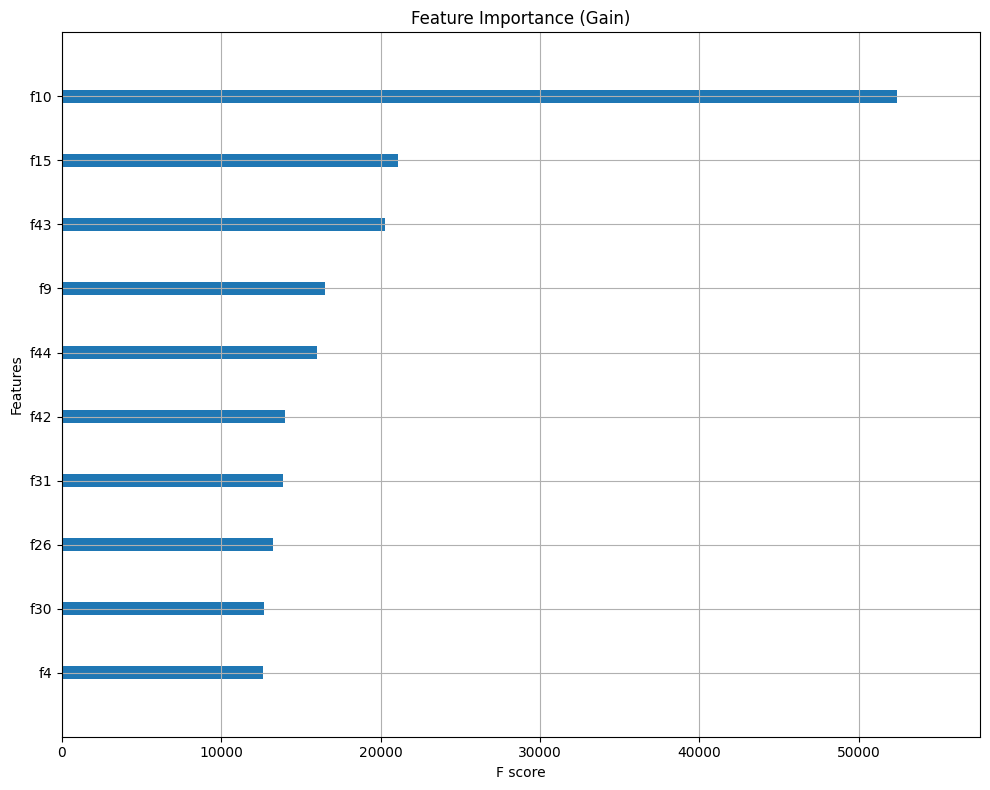

In [184]:
# End any existing MLFlow runs to avoid conflicts
mlflow.end_run()

# Start MLFlow run for model explainability
with mlflow.start_run(experiment_id=experiment_id, run_name="model_explainability"):
    # Load the model for explainability analysis
    xgc = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))
    
    # Generate and save feature importance plots
    fig, ax = plt.subplots(figsize=(10, 8))
    xgb.plot_importance(xgc, importance_type="gain", max_num_features=10, show_values=False, ax=ax)
    plt.title("Feature Importance (Gain)")
    plt.tight_layout()
    
    # Save the plot as local artifact
    importance_plot_path = os.path.join(MODEL_ROOT, "feature_importance_gain.png")
    plt.savefig(importance_plot_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(importance_plot_path)
    plt.show()
    
    # Get feature importance scores and log as metrics
    importance_dict = xgc.get_score(importance_type='gain')
    for feature, importance in importance_dict.items():
        mlflow.log_metric(f"feature_importance_{feature}", importance)
    
    # Save feature importance as JSON artifact
    importance_json_path = os.path.join(MODEL_ROOT, "feature_importance.json")
    with open(importance_json_path, 'w') as f:
        json.dump(importance_dict, f, indent=2)
    mlflow.log_artifact(importance_json_path)

Based on the above we see that the top three features driving the predictions of the model are:

* checking_account_A14 - lack of a checking account
* credit_history_A34 - critical account / has credits outside of the bank
* property_A121 - real estate

We could also look at the other importance metrics, just for completeness.

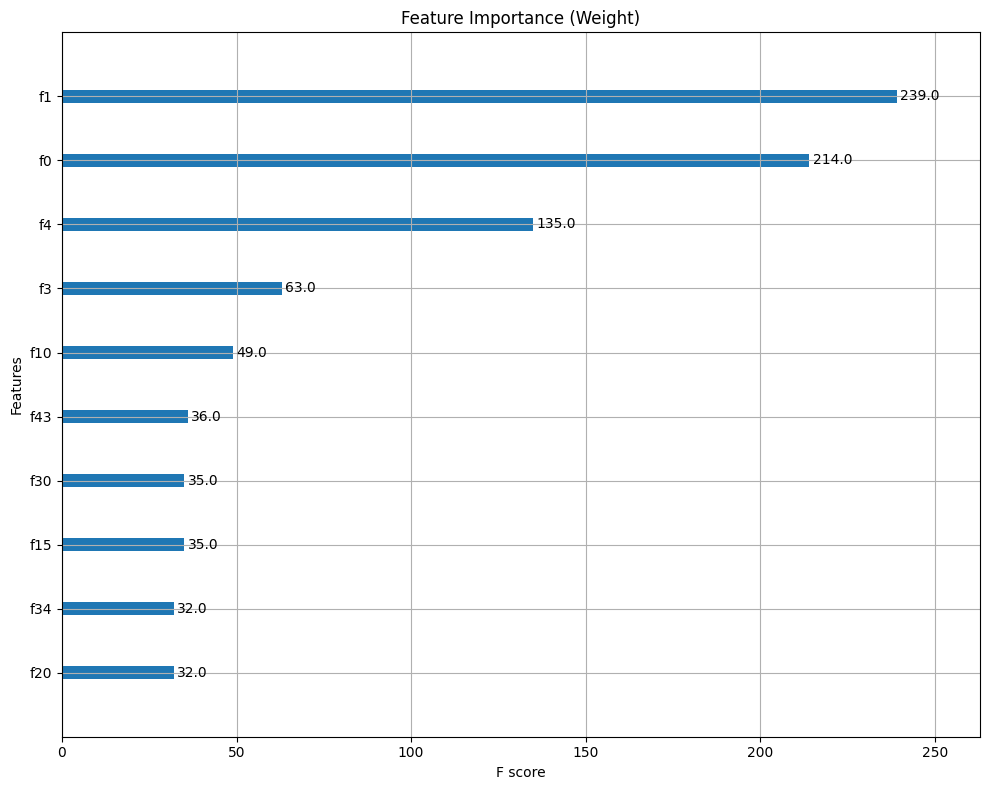

In [185]:
    # Generate weight importance plot
    fig, ax = plt.subplots(figsize=(10, 8))
    xgb.plot_importance(xgc, importance_type="weight", max_num_features=10, ax=ax)
    plt.title("Feature Importance (Weight)")
    plt.tight_layout()
    
    # Save the plot as local artifact
    weight_plot_path = os.path.join(MODEL_ROOT, "feature_importance_weight.png")
    plt.savefig(weight_plot_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(weight_plot_path)
    plt.show()

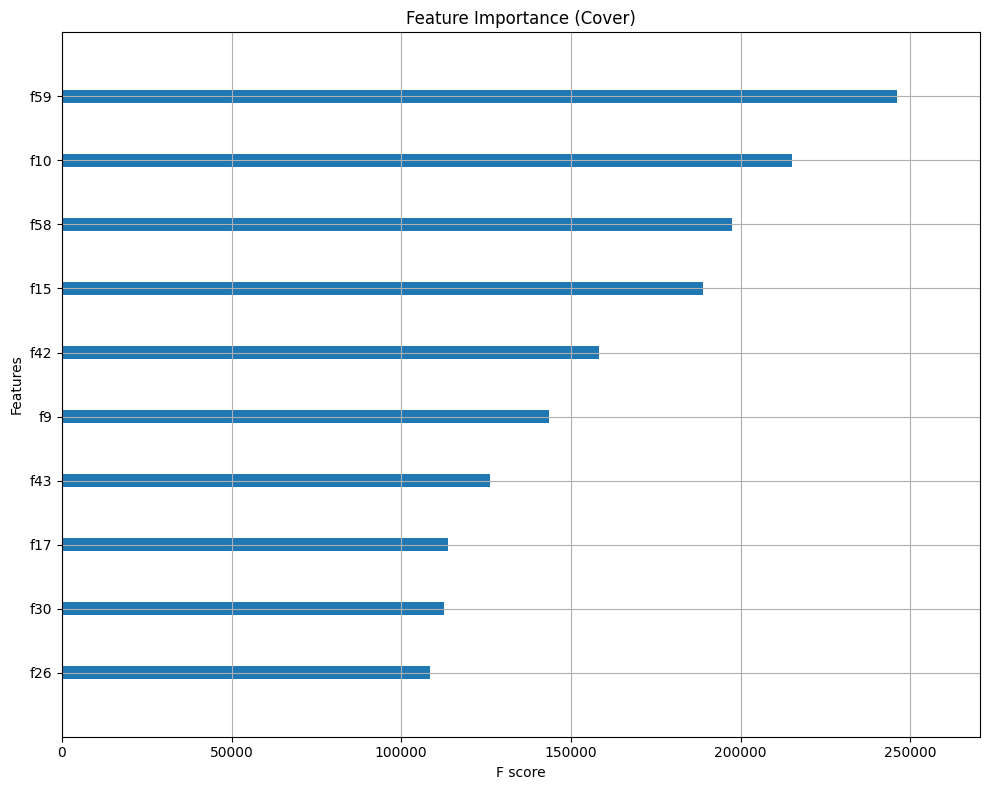

In [186]:
    # Generate cover importance plot
    fig, ax = plt.subplots(figsize=(10, 8))
    xgb.plot_importance(xgc, importance_type="cover", max_num_features=10, show_values=False, ax=ax)
    plt.title("Feature Importance (Cover)")
    plt.tight_layout()
    
    # Save the plot as local artifact
    cover_plot_path = os.path.join(MODEL_ROOT, "feature_importance_cover.png")
    plt.savefig(cover_plot_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(cover_plot_path)
    plt.show()

ELI5 is another popular libarary for model explainability. This package is used to debug machine learning classifiers and explain their predictions. 

Unlike XGBoost, which is confined to explaining its own models only, ELI5 provides support for other frameworks like *scikit-learn*, *Keras*, *LightGBM* and others. It can also explain black-box models (i.e. Neural Networks) using [LIME](https://www.dominodatalab.com/blog/explaining-black-box-models-using-attribute-importance-pdps-and-lime).

First, ELI5 also provides a way of calculating the feature importance. Let's test it and make sure it agrees with the original XGBoost calculation (based on gain).

In [187]:
    # Generate ELI5 feature weights explanation
    # Use a simpler approach to avoid feature name mismatches
    import io
    from contextlib import redirect_stdout
    
    # Capture ELI5 output as string
    f = io.StringIO()
    with redirect_stdout(f):
        try:
            eli5_display = eli5.show_weights(xgc)
            eli5_html = eli5_display.data
        except:
            # If ELI5 fails, create a simple HTML with feature importance from XGBoost
            importance_dict = xgc.get_score(importance_type='gain')
            eli5_html = f"<html><body><h2>Feature Importance (XGBoost Gain)</h2>"
            for feature, importance in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True):
                eli5_html += f"<p>{feature}: {importance:.4f}</p>"
            eli5_html += "</body></html>"
    
    # Save ELI5 weights explanation as HTML
    eli5_weights_path = os.path.join(MODEL_ROOT, "eli5_feature_weights.html")
    with open(eli5_weights_path, 'w') as f:
        f.write(eli5_html)
    mlflow.log_artifact(eli5_weights_path)
    
    # Display the weights
    try:
        eli5.show_weights(xgc)
    except Exception as e:
        print(f"ELI5 feature weights display failed: {e}")
        print("Showing XGBoost feature importance instead:")
        importance_dict = xgc.get_score(importance_type='gain')
        for feature, importance in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
            print(f"{feature}: {importance:.4f}")

A more interesting function is `show_predictions`, which returns an explanation of the decision behind individual predictions. In other words, we can see what features drove the model to predict one outcome or the other.

Feel free to experiment with the code below, changing the `id` value and observing what features the model uses to calculate its prediction, and if the prediction agrees with the actual value. The `id` variable represents an observation number from the test dataset.

In [188]:
    # Individual prediction explanation with ELI5
    df_test_X = df_test.drop(target_col, axis=1)
    id = 3 # <- change this to see results for different observations  

    print("Actual Label: %s" % actuals.iloc[id])
    print("Predicted: %s" % pred_class[id])
    
    # Try ELI5 prediction explanation with fallback
    try:
        eli5_display = eli5.show_prediction(xgc, df_test_X.iloc[id], 
                             feature_names=list(df_test_X.columns),
                             show_feature_values=True)
        eli5_prediction_html = eli5_display.data
    except Exception as e:
        print(f"ELI5 prediction explanation failed: {e}")
        # Create a simple fallback HTML
        eli5_prediction_html = f"""<html><body>
        <h2>Prediction Explanation for Sample {id}</h2>
        <p>Actual Label: {actuals.iloc[id]}</p>
        <p>Predicted: {pred_class[id]}</p>
        <p>Prediction Probability: {predictions[id]:.4f}</p>
        <p>ELI5 explanation failed due to feature name mismatch.</p>
        </body></html>"""
    
    # Save individual prediction explanation as HTML
    eli5_prediction_path = os.path.join(MODEL_ROOT, f"eli5_prediction_sample_{id}.html")
    with open(eli5_prediction_path, 'w') as f:
        f.write(eli5_prediction_html)
    mlflow.log_artifact(eli5_prediction_path)
    
    # Display the prediction explanation
    try:
        eli5.show_prediction(xgc, df_test_X.iloc[id], 
                             feature_names=list(df_test_X.columns),
                             show_feature_values=True)
    except Exception as e:
        print(f"ELI5 prediction display failed: {e}")
        print(f"Sample features: {df_test_X.iloc[id].to_dict()}")

Actual Label: 1
Predicted: 1
ELI5 prediction explanation failed: 'checking_account_A14'


This concludes the model training notebook demo.

In [189]:
# Set some default values
column_names_all = ['duration', 'credit_amount', 'installment_rate', 'residence', 'age', 'credits', 'dependents', 'checking_account_A11', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 'credit_history_A30', 'credit_history_A31',
                    'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 
                    'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_since_A71', 'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 'status_A91', 'status_A92', 'status_A93', 'status_A94', 
                    'debtors_guarantors_A101', 'debtors_guarantors_A102', 'debtors_guarantors_A103', 'property_A121', 'property_A122', 'property_A123', 'property_A124', 'other_installments_A141', 'other_installments_A142', 'other_installments_A143', 'housing_A151', 
                    'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 'job_A173', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']

sample_data = [[0.4705882352941176, 0.3685484758446132, 0.3333333333333333, 0.3333333333333333, 
                0.2857142857142857, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]]

In [190]:
df_all = pd.DataFrame(sample_data, columns=column_names_all)

In [191]:
for col in ['checking_account_A11', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 
                'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 
                'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 
                'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 
                'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_since_A71', 
                'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 
                'status_A91', 'status_A92', 'status_A93', 'status_A94', 'debtors_guarantors_A101', 
                'debtors_guarantors_A102', 'debtors_guarantors_A103', 'property_A121', 'property_A122', 
                'property_A123', 'property_A124', 'other_installments_A141', 'other_installments_A142', 
                'other_installments_A143', 'housing_A151', 'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 
                'job_A173', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']:
    df_all[col] = df_all[col].astype('int')


In [192]:
eli5.show_prediction(xgc, df_all.iloc[0], 
                         feature_names=list(df_all.columns),
                         show_feature_values=True)

In [193]:
df_all.iloc[0]

duration               0.470588
credit_amount          0.368548
installment_rate       0.333333
residence              0.333333
age                    0.285714
                         ...   
job_A174               1.000000
telephone_A191         0.000000
telephone_A192         1.000000
foreign_worker_A201    1.000000
foreign_worker_A202    0.000000
Name: 0, Length: 61, dtype: float64

In [194]:
df_all.iloc[0]["checking_account_A14"]

0.0

In [195]:
df_prediction = eli5.explain_prediction_df(xgc, df_all.iloc[0], 
                         feature_names=list(df_all.columns))

In [196]:
df_prediction.head(10).style.background_gradient(cmap = "Greens").hide()

target,feature,weight,value
y,credit_amount,0.581611,0.368548
y,purpose_A41,0.440962,1.000000
y,age,0.403189,0.285714
y,status_A93,0.078115,1.000000
y,telephone_A192,0.069136,1.000000
y,employment_since_A73,0.047671,1.000000
y,property_A123,0.047316,1.000000
y,checking_account_A11,0.045892,0.000000
y,job_A173,0.027161,0.000000
y,installment_rate,0.022013,0.333333


In [197]:
    # Generate explanation for sample data with fallback
    try:
        eli5_display = eli5.show_prediction(xgc, df_all.iloc[0], 
                                 feature_names=list(df_all.columns),
                                 show_feature_values=True)
        sample_prediction_html = eli5_display.data
    except Exception as e:
        print(f"ELI5 sample prediction explanation failed: {e}")
        # Create a simple fallback HTML
        sample_prediction_html = f"""<html><body>
        <h2>Sample Prediction Explanation</h2>
        <p>ELI5 explanation failed due to feature name mismatch.</p>
        <p>Sample data shape: {df_all.iloc[0].shape}</p>
        </body></html>"""
    
    # Save sample prediction explanation
    sample_prediction_path = os.path.join(MODEL_ROOT, "eli5_sample_prediction.html")
    with open(sample_prediction_path, 'w') as f:
        f.write(sample_prediction_html)
    mlflow.log_artifact(sample_prediction_path)
    
    # Try to save the prediction dataframe from ELI5
    try:
        df_prediction = eli5.explain_prediction_df(xgc, df_all.iloc[0], 
                                 feature_names=list(df_all.columns))
        prediction_df_path = os.path.join(MODEL_ROOT, "eli5_prediction_df.csv")
        df_prediction.to_csv(prediction_df_path, index=False)
        mlflow.log_artifact(prediction_df_path)
    except Exception as e:
        print(f"ELI5 prediction dataframe generation failed: {e}")
        # Create a simple alternative
        simple_df = pd.DataFrame({
            'feature': list(df_all.columns)[:10],
            'value': df_all.iloc[0].values[:10]
        })
        prediction_df_path = os.path.join(MODEL_ROOT, "simple_prediction_df.csv")
        simple_df.to_csv(prediction_df_path, index=False)
        mlflow.log_artifact(prediction_df_path)
    
    print("Model explainability analysis completed and logged to MLFlow")

Model explainability analysis completed and logged to MLFlow


## MLFlow Integration Summary

This notebook has been enhanced with comprehensive MLFlow experiment tracking. Here's what gets logged:

### MLFlow Experiments and Runs:
- **Parent Experiment**: Credit_Risk_Model_[timestamp]
- **Single Model Training Run**: Parameters, metrics, model artifacts
- **Hyperparameter Tuning Run**: Parent run with child runs for each trial
- **Best Model Run**: Final best performing model
- **Model Evaluation Run**: Test set performance metrics
- **Model Explainability Run**: Feature importance and prediction explanations

### Local Artifacts Created (in `/mnt/artifacts/`):
- `single_model.xgb` - Initial trained model
- `tune_best.xgb` - Best hyperparameter tuned model
- `trial_results.json` - Summary of all hyperparameter trials
- `test_predictions.csv` - Test set predictions and actual values
- `feature_importance_gain.png` - Feature importance plot (gain)
- `feature_importance_weight.png` - Feature importance plot (weight)
- `feature_importance_cover.png` - Feature importance plot (cover)
- `feature_importance.json` - Feature importance scores
- `eli5_feature_weights.html` - ELI5 feature weights explanation
- `eli5_prediction_sample_[id].html` - Individual prediction explanation
- `eli5_sample_prediction.html` - Sample data prediction explanation
- `eli5_prediction_df.csv` - ELI5 prediction dataframe

### MLFlow Artifacts:
All local artifacts are also logged to MLFlow along with models, parameters, and metrics for complete experiment tracking and reproducibility.